In [75]:
import pandas as pd
import os
import re
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community.label_propagation import label_propagation_communities
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import difflib


import geopandas as gpd

from libs.mrqap import MRQAP # source: https://github.com/lisette-espin/mrqap-python
import geopy.distance
import itertools


In [76]:
_DATA_DIRECTORY = 'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\'
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

In [77]:
# relative paths weren't working for me for some damn reason
from os import listdir
from os.path import isfile, join
os.listdir("data")
os.getcwd()
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022'

In [78]:
# Data imports here my duder
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"
data_1 = pd.read_excel("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\ESC-2014-first_semi-final-full_results.xls")

In [79]:
# this is a function that allows you to get data from any year or voting type or round type 

def Eurovision_Decade_DataFrame(csv_path, vote_type = "Both", round_type = "all", y1="NA", y2="NA"):
    # probably enforce types or something here
    
    
    longform_data = pd.read_csv(csv_path)
    longform_data = longform_data[longform_data["From country"] != longform_data_decades["To country"]]
    longform_data = longform_data.replace('F.Y.R. Macedonia','Macedonia')
    contest_round = list(longform_data['(semi-) final'].unique())
    for version in contest_round:
        locals()["census_"+str(version)] = longform_data[longform_data['(semi-) final']==version].groupby('Year').nunique()[['From country','To country']]
        locals()["census_"+str(version)]['(semi-) final'] = str(version)
        locals()["census_"+str(version)].reset_index()
        locals()["census_"+str(version)].rename(columns = {'From country':'sum_senders_'+str(version), 'To country':'sum_receivers_'+str(version)}, inplace = True)
        if contest_round.index(version) == 0: 
            merged_rounds = pd.merge(longform_data, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
        else:
            merged_rounds = pd.merge(merged_rounds, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
    merged_rounds = merged_rounds.fillna(0)

    merged_rounds["sum_senders"] = merged_rounds["sum_senders_sf"] + merged_rounds["sum_senders_sf1"] + merged_rounds["sum_senders_f"] + merged_rounds["sum_senders_sf2"] 
    merged_rounds["sum_receivers"] = merged_rounds["sum_receivers_sf"] + merged_rounds["sum_receivers_sf2"] + merged_rounds["sum_receivers_f"]  + merged_rounds["sum_receivers_sf1"] 
    merged_rounds = merged_rounds.drop(['sum_senders_sf', 'sum_senders_sf1', "sum_senders_f", 'sum_senders_sf2', 'sum_receivers_sf', "sum_receivers_sf2", "sum_receivers_f", "sum_receivers_sf1"], axis=1)
    merged_rounds['Decade'] = (10 * (merged_rounds['Year'] // 10)).astype(str) + 's'
    merged_rounds["average_points"] = merged_rounds["Points"]/merged_rounds["sum_senders"]
    
    if round_type != "all" and round_type == "finals":
        merged_rounds = merged_rounds[merged_rounds['(semi-) final'] == "f"]
    elif round_type != "all" and round_type == "semis":
        merged_rounds = merged_rounds[(merged_rounds['(semi-) final'] == "sf") | (merged_rounds['(semi-) final'] == "sf1") | (merged_rounds['(semi-) final'] == "sf2")]
    else:
        pass
    merged_rounds["contests_incl"] = str(round_type)
    
    if y1 != "NA" and y2 != "NA":
        merged_rounds = merged_rounds[(merged_rounds['Year'] >= y1) & (merged_rounds['Year'] <= y2)]
    else:
        pass
    
    if vote_type == "J" or vote_type == "T":
        merged_rounds = merged_rounds[merged_rounds["Jury or Televoting"] == vote_type]
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    else:
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    decade_grouping["Contests_Shared"] = (decade_grouping["Year"]/2000).round(0).astype(int)
    return decade_grouping


In [80]:
# this is a function to find similar countries for fuzzy matching
def similar(landstring, country):
    shitter = process.extractOne(landstring, country, score_cutoff=90)
    if shitter == None:
        return "NA"
    else:
        return shitter[0]
    

In [81]:
# fn for merging on keys that match at the 90% threshold
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [82]:
# helper function to subset the data by decade (not really super needed)
def Decade_subset(df_decades, decade="all"):
    if decade == "all":
        return df_decades     
    else:
        locals()["eurovision_"+str(decade)] = df_decades[df_decades["Decade"] == str(decade)+"s"].sort_values(by=['average_points'],  ascending=False)
        return locals()["eurovision_"+str(decade)]

In [83]:
# function for getting network and its community properties
# maybe it would be best to split this function up somehow...
%matplotlib inline
def network_and_communities(dataframe, show_plot = "N"):
    dataframe_network = nx.from_pandas_edgelist(dataframe, "From country", "To country", ["average_points"])
    communities = label_propagation_communities(dataframe_network)
    print([community for community in communities])

    
    nx.draw(dataframe_network)
    if show_plot == "Y":
        plt.show()
    else:
        pass
    return dataframe_network


In [84]:
# some function to subset the duders by their favorites

# the nlargest memer isn't working properly, needs to be the top of each country methinks...

# need to redo the flow of this, if years is something then it doesn't return what I want 
def cutoff_values(dataframe, min_years_with = "all", top="NA", points="NA"):
    if min_years_with != "all" and top != "NA":
        dataframe = dataframe[dataframe["Contests_Shared"] >= min_years_with]
    else:
        if top != "NA":
            favorites = dataframe.nlargest(top, 'average_points')
        else:
            pass
        if points != "NA":
            favorites = dataframe[dataframe["average_points"] >= points]
        else:
            pass
    return favorites

In [85]:
# some function to give some basic characteristics of whatever network is passed to it..
def network_characteristics(dataframe, weight = "average_points"):
    network_of_interest = nx.from_pandas_edgelist(dataframe, "From country", "To country", [weight],
                                   create_using=nx.DiGraph())
    census = nx.triadic_census(network_of_interest)
    centrality = nx.degree_centrality(network_of_interest)
    centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality']).sort_values(by=["centrality"], ascending=False)
    return census, centrality
    

In [86]:
# this is testing of the functions... it works...

longform_data_decades = pd.read_csv("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv")
shitteringo = list(longform_data_decades['(semi-) final'].unique())
shitteringo.index('f')


testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "semis")

In [87]:

def proc_english(dataframe):
    english = pd.read_csv(full_path(dataframe),  header=0,  skiprows=1)
    english = english.rename(columns = {'%':'percent_english'})
    english["percent_english"] = english["percent_english"].str.replace("2012", "")
    english["percent_english"] =  [re.sub(r"\((.*?)\)", "", str(x)) for x in english["percent_english"]]

    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), english["Country"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    eng_data = fuzzy_merge(english, match_dict, 'Country', 'Country', threshold=90, limit=1)
    eng_data['matches'].replace('', np.nan, inplace=True)
    eng_data.dropna(subset=['matches'], inplace=True)
    eng_data = eng_data.drop(['Country'], axis=1)
    eng_data["percent_english"] = eng_data["percent_english"].astype(float)
    eng_data = eng_data.drop(['No.', 'Eligible population', 'No..1', '%.1', 'No..2', '%.2', 'Notes'], axis=1)
    return eng_data



In [88]:
# this function grabs the data for gdp per capita and cleans it
def proc_gdppc(dataframe, year = "all"):
    gdp_per_capita = pd.read_csv(full_path(dataframe),  header=0)
    if year != "all":
        gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == int(year)]
    else:
        pass
    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), gdp_per_capita["Entity"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    merged_data = fuzzy_merge(gdp_per_capita, match_dict, 'Entity', 'Country', threshold=90, limit=1)
    merged_data['matches'].replace('', np.nan, inplace=True)
    merged_data.dropna(subset=['matches'], inplace=True)
    merged_data = merged_data.drop(['Code', 'Entity'], axis=1)
    merged_data.rename(columns={r"GDP per capita, PPP (constant 2017 international $)": "GDP_PPP_2017_dol"}, errors="raise", inplace=True)
    merged_data["GDP_PPP_2017_dol"] = merged_data["GDP_PPP_2017_dol"].round(2)
    return merged_data

In [89]:
# this function grabs the data for distance and cleans it and finds the distance in kilometers
def proc_distance(dataframe):
    country = [row[0].strip() for row in csv.reader(open(full_path(dataframe)), delimiter=';')]
    pos = dict((land, similar(land.upper(), country)) for land in testererer["From country"].unique())
    take_2_2 = pd.DataFrame.from_dict(pos, orient='index')
    take_2_2.reset_index()
    take_2_2['Country'] = take_2_2.index
    fuzzy_merged = fuzzy_merge(shitter_coords, take_2_2, "Country", "Country", threshold=90, limit=1)
    fuzzy_merged['matches'].replace('', np.nan, inplace=True)
    fuzzy_merged.dropna(subset=['matches'], inplace=True)
    fuzzy_merged = fuzzy_merged.drop(['Country'], axis=1)
    print(len(fuzzy_merged["matches"]))
    dictionary_pos = fuzzy_merged.set_index('matches').T.to_dict('list')

    # for val in dictionary_pos:
    list_new = []
    for a, b in itertools.combinations(dictionary_pos, 2):
        list_new.append({"Country_A": a, "Country_B": b, "Distance": round(geopy.distance.geodesic(dictionary_pos[a], dictionary_pos[b]).km, 2)})

    distance_matrix = pd.DataFrame.from_dict(list_new)
    return distance_matrix



[{'Germany', 'Belgium', 'Denmark', 'Portugal'}, {'Switzerland', 'Luxembourg', 'Austria', 'Norway', 'Sweden', 'United Kingdom', 'Ireland'}, {'Spain', 'Italy', 'Yugoslavia', 'Turkey'}]


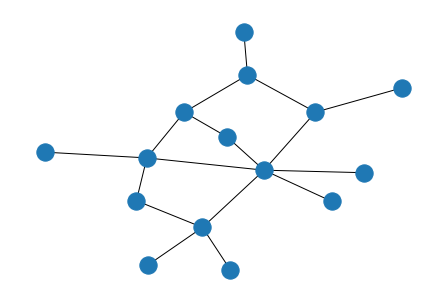

In [90]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1980")

network_and_communities(cutoff_values(testererer,  min_years_with = 5, points = 3), show_plot = "Y")

[{'Cyprus', 'Greece'}, {'France', 'Norway'}, {'Iceland', 'Sweden'}, {'United Kingdom', 'Belgium', 'Ireland'}]


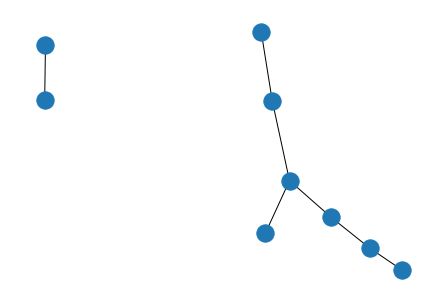

In [91]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1990")

network_and_communities(cutoff_values(testererer, top = 8), show_plot = "Y")

[{'Germany', 'The Netherlands', 'France', 'Turkey'}, {'Bosnia & Herzegovina', 'Croatia', 'Slovenia'}, {'Estonia', 'Latvia', 'Russia'}, {'Denmark', 'Iceland', 'Sweden'}, {'Cyprus', 'Greece'}, {'United Kingdom', 'Ireland'}]


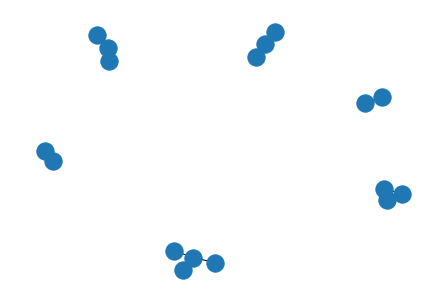

In [92]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2000, y2 = 2006), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Belgium', 'Germany', 'Albania', 'France', 'Macedonia', 'United Kingdom', 'Turkey'}, {'Armenia', 'Israel', 'Russia'}, {'Switzerland', 'Portugal'}, {'Bosnia & Herzegovina', 'Slovenia'}, {'Finland', 'Iceland', 'Sweden'}]


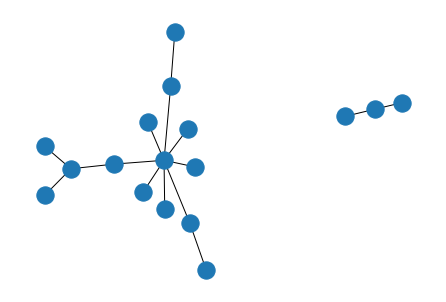

In [93]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2006, y2 = 2010), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Germany', 'Belgium', 'France', 'The Netherlands', 'Turkey'}, {'Estonia', 'Lithuania', 'Latvia', 'Russia'}, {'Cyprus', 'Greece'}, {'Denmark', 'Iceland', 'Sweden'}, {'Bosnia & Herzegovina', 'Croatia', 'Slovenia'}]


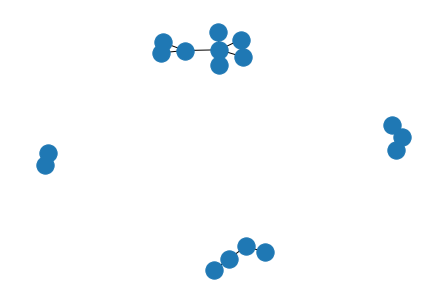

In [94]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Albania', 'Greece'}, {'Romania', 'Moldova', 'Russia'}, {'Denmark', 'Norway', 'Sweden'}, {'United Kingdom', 'Lithuania', 'Ireland'}, {'Serbia', 'Macedonia'}, {'Azerbaijan', 'Georgia'}, {'Belarus', 'Ukraine'}]


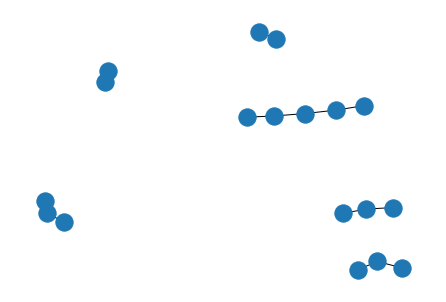

In [95]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2010")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Armenia', 'Greece'}, {'United Kingdom', 'Lithuania', 'Ireland'}, {'Serbia', 'Switzerland', 'Slovenia', 'Hungary'}, {'Bulgaria', 'Israel', 'Macedonia'}, {'Azerbaijan', 'Czech Republic'}, {'Denmark', 'Norway'}, {'Poland', 'Italy', 'Ukraine'}]


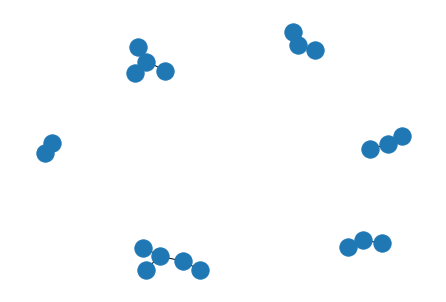

In [96]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "T")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Romania', 'Moldova', 'Russia'}, {'Cyprus', 'Albania', 'Greece'}, {'Germany', 'France', 'Turkey'}, {'The Netherlands', 'Denmark', 'Norway', 'Sweden'}, {'Azerbaijan', 'Georgia', 'Armenia'}]


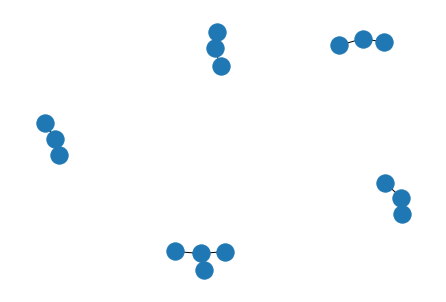

In [97]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "J")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Albania', 'Greece'}, {'Romania', 'Moldova', 'Russia'}, {'Denmark', 'Norway', 'Sweden'}, {'United Kingdom', 'Lithuania', 'Ireland'}, {'Serbia', 'Macedonia'}, {'Azerbaijan', 'Georgia'}, {'Belarus', 'Ukraine'}]


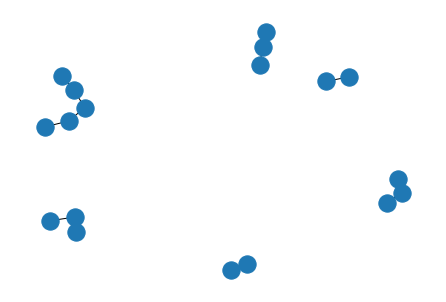

In [98]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Belgium', 'Belarus', 'Slovenia', 'Croatia', 'San Marino', 'Norway', 'Russia', 'Bosnia & Herzegovina', 'Romania', 'Israel', 'Monaco', 'Andorra', 'Spain', 'Luxembourg', 'France', 'Iceland', 'Austria', 'Ukraine', 'Greece', 'Yugoslavia', 'Serbia & Montenegro', 'Sweden', 'Portugal', 'Ireland', 'Turkey', 'Malta', 'Czech Republic', 'Poland', 'Latvia', 'Finland', 'Montenegro', 'The Netherands', 'Cyprus', 'Morocco', 'The Netherlands', 'United Kingdom', 'Denmark', 'Moldova', 'Germany', 'Switzerland', 'Albania', 'Estonia', 'Serbia', 'Italy', 'Armenia', 'Macedonia', 'Hungary', 'Australia', 'Slovakia', 'Azerbaijan', 'Georgia', 'Bulgaria', 'Lithuania'}]


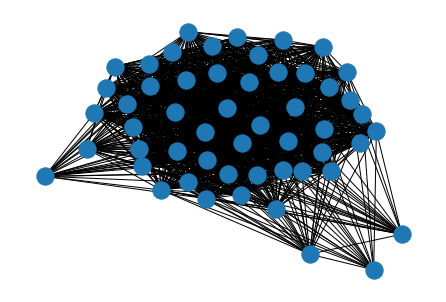

In [99]:
# I guess louvain probably works the best for getting these labels without struggle
from community import community_louvain
partition = community_louvain.best_partition(network_and_communities(testererer))
partition

count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]

In [100]:
clusters_df = pd.DataFrame.from_dict(partition, orient='index', columns=['cluster']).reset_index()
clusters_df.rename(columns={"index": "Country"}, errors="raise", inplace=True)
clusters_df

,Country,cluster
0,Austria,0
1,Belgium,1
2,Denmark,0
3,Finland,0
4,France,0
5,Germany,0
6,Greece,0
7,Ireland,0
8,Israel,1
9,Italy,0


In [101]:
# this was stolen from:
# https://github.com/DataMettle/eurovision/blob/master/Modelling%20Eurovision%20voting%20patterns.ipynb


# Download the file: Done!
# https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
# and place the contents of the zip in the data folder.

country_codes = pd.read_csv(full_path('country_codes.csv'))

shapefile = full_path('ne_10m_admin_0_countries.shp')
shape = gpd.read_file(shapefile)
gdf = shape.to_crs("+init=epsg:3035")
gdf_australia = shape.to_crs("+init=epsg:3577")

# Each country needs to be outputted with a label..
# take this from our network outputs
# clusters_df = pd.DataFrame(
#     {
#         'Country': countries,
#         'cluster': clusters,
#     }
# )


def merge_with_map(map_df, country_codes):
    """Adds full country names to country codes. Also adjusts some country names."""
    return (
        pd.merge(map_df, country_codes)
        .replace({'Russian Federation': 'Russia',
                  'Netherlands': 'The Netherlands',
                  'Czechia': 'Czech Republic',
                  'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                  'Moldova, Republic of': 'Moldova',
                  'Macedonia, the former Yugoslav Republic of': 'F.Y.R. Macedonia'})
    )

eurovision_map = merge_with_map(gdf, country_codes)

eurovision_map_australia = merge_with_map(gdf_australia, country_codes)

C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


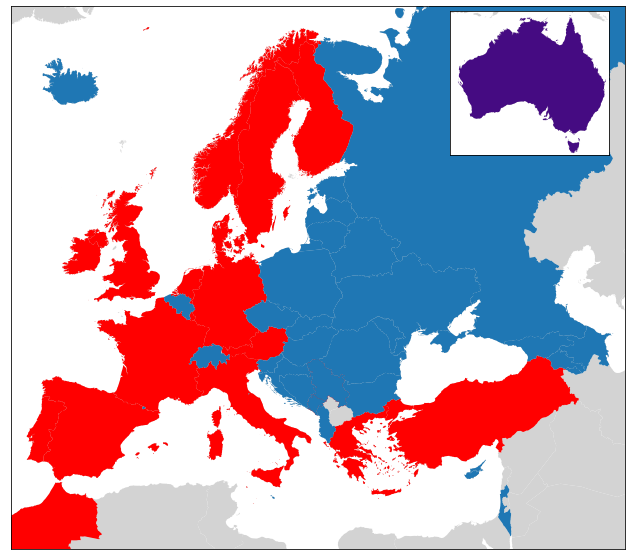

In [102]:
# This shit is straight up stolen from kaggle so probably change parts of it!

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, ax = plt.subplots(1, figsize=(11, 10))
f.subplots_adjust(hspace=0.0, wspace=0.0)
gdf.plot(ax=ax, color='lightgrey')

eurovision_map_cluster = pd.merge(eurovision_map, clusters_df, left_on='Country name', right_on='Country')


# Gonna have to change the cmap s.t. any number of colors are taken.. maybe some viridis color pallete or something
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 0].plot(ax=ax,
                                                                    color='r',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 1].plot(ax=ax,
                                                                    vmin=-0.05)

eurovision_map_australia_cluster = pd.merge(eurovision_map_australia, clusters_df, left_on='Country name', right_on='Country')
inset_ax = inset_axes(ax, 
                      width=1.5*(2.5/1.5),
                      height=1.2*(2.5/1.5),
                      loc=1)
gdf_australia.plot(ax=inset_ax, color='lightgrey')
eurovision_map_australia_cluster.plot(ax=inset_ax,
                                      cmap='Purples',
                                      vmin=-0.05)
inset_ax.set_xlim(-0.21e7, 0.22e7)
inset_ax.set_ylim(-0.49e7, -0.1e7)
inset_ax.axes.get_xaxis().set_visible(False)
inset_ax.axes.get_yaxis().set_visible(False)

# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 2].plot(ax=ax,
#                                                                     color='g',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 3].plot(ax=ax,
#                                                                     color='y',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 4].plot(ax=ax,
#                                                                     color='m',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 5].plot(ax=ax,
#                                                                     color='purple',
#                                                                     vmin=-0.05)

ax.set_xlim(0.25e7, 0.77e7)
ax.set_ylim(0.10e7, 0.56e7)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
# plt.savefig('images/clusters_map.png', bbox_inches='tight', dpi=150)

In [103]:
# # load geographic coordinate system for countries
import csv
country = [row[0].strip() for row in csv.reader(open(full_path("LonLat.csv")), delimiter=';')]    # clear spaces

shitter_coords = pd.read_csv(full_path("LonLat.csv"), delimiter=";", 
                  names=["Country", "Lat", "Lon"])
shitter_coords

,Country,Lat,Lon
0,AFGHANISTAN,33.0000,65.0
1,ALBANIA,41.0000,20.0
2,ALGERIA,28.0000,3.0
3,AMERICAN SAMOA,-14.3333,-170.0
4,ANDORRA,42.5000,1.5
...,...,...,...
230,WESTERN SAHARA,24.5000,-13.0
231,YEMEN,15.0000,48.0
232,ZAIRE,-20.0000,30.0
233,ZAMBIA,-15.0000,30.0


In [104]:
# data load ins for the MRQAP

distance_data = proc_distance("LonLat.csv")
point_shares = testererer.groupby(["From country", "To country"]).sum()
point_shares = point_shares.reset_index()
point_shares.columns = [c.replace(' ', '_') for c in point_shares.columns]
bilateral_flows = pd.read_csv(full_path("BACI_trade_data.csv"),  encoding='latin-1')


51


C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  del sys.path[0]


In [107]:
# Generating an intersection of the countries s.t. there are only mutual countries in each dataframe..

acceptable_countries = list(set(distance_data["Country_A"]).intersection(point_shares["To_country"].unique()))
acceptable_countries = list(set(acceptable_countries).intersection(bilateral_flows["From_country"].unique()))

distance_data = distance_data[(distance_data['Country_A'].isin(acceptable_countries)) & (distance_data['Country_B'].isin(acceptable_countries))]
point_shares = point_shares[(point_shares["To_country"].isin(acceptable_countries)) & (point_shares['From_country'].isin(acceptable_countries))]
bilateral_flows = bilateral_flows[(bilateral_flows["To_country"].isin(acceptable_countries)) & (bilateral_flows['From_country'].isin(acceptable_countries))]




In [108]:
# getting the average points for the dependent variable in our QAP
point_shares = point_shares[(point_shares['From_country'].isin(acceptable_countries)) & (point_shares['To_country'].isin(acceptable_countries))]

# can check if points instead of average_points is to be used here....
point_shares = point_shares.drop(['Year', 'Points', 'sum_senders', 'sum_receivers', 'Contests_Shared'], axis=1)
point_shares = point_shares.drop(point_shares.columns[2], axis=1)
point_shares

df = pd.crosstab(point_shares.From_country, point_shares.To_country, point_shares.average_points, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_points = df.fillna(0)
# df_points = df_points + df_points.T - np.diag(np.diag(df_points))
df_points

,Andorra,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,...,Morocco,Norway,Poland,Portugal,Romania,Slovenia,Spain,Sweden,Switzerland,Turkey
Andorra,0.000000,0.000000,0.203297,0.211988,0.000000,0.000000,0.166667,0.448718,0.000000,1.584357,...,0.000000,0.860252,0.238095,1.910252,1.084808,0.190476,1.521599,1.005180,0.268498,0.500000
Australia,0.000000,0.000000,0.259136,2.550000,1.595238,0.047619,0.734219,1.646844,0.511047,0.521595,...,0.000000,1.408970,0.666667,1.095238,0.288095,0.714286,0.329457,3.150498,0.047619,0.000000
Austria,0.000000,0.657143,0.000000,3.181882,2.401440,3.760196,1.278284,4.679030,2.335090,1.869534,...,0.000000,2.682579,2.026416,1.360817,3.203408,1.276882,3.180771,6.629516,5.832364,2.323762
Belgium,0.000000,2.195238,5.236455,0.000000,1.588745,0.776945,3.542547,4.746763,1.323056,1.759166,...,0.000000,5.242310,2.170638,3.783547,2.524962,0.706004,5.157726,7.640525,5.324166,4.405260
Bulgaria,0.000000,1.214286,2.622571,2.103896,0.000000,1.464089,2.473817,1.146176,0.648243,0.478127,...,0.000000,1.047248,0.595238,0.493939,1.774338,0.530303,0.217949,1.040053,0.460256,3.321428
Croatia,0.047619,0.547619,1.799355,0.583266,1.908990,0.000000,3.571429,2.551548,1.142692,0.669173,...,0.000000,2.130405,0.466520,1.415805,0.963539,4.475820,1.491405,1.420879,0.945967,2.150721
Cyprus,0.000000,0.980952,2.613758,2.549485,3.768904,2.345022,0.000000,3.448596,1.559328,1.755092,...,0.000000,3.523493,0.817088,2.182778,2.973200,0.811009,4.828843,5.929963,2.842893,0.418803
Denmark,0.000000,3.098117,4.439364,4.758279,2.014598,0.241627,3.370132,0.000000,2.863314,2.076725,...,0.000000,8.672882,1.022699,1.068846,2.303855,0.859760,1.634013,14.671541,4.483253,2.932408
Estonia,0.261905,0.625000,3.319430,3.494451,2.004782,1.111371,2.698864,4.702369,0.000000,5.383317,...,0.000000,4.874508,0.777656,0.819767,1.291173,0.651176,0.372750,6.846280,0.896770,0.489084
Finland,0.119048,1.101190,3.989075,5.531667,1.258532,0.835812,4.405253,3.934777,6.380706,0.000000,...,0.000000,5.911314,0.534286,3.254853,1.212840,0.644771,3.692011,9.399126,6.479288,1.992559


In [109]:
# How to get adjacency matrix...
df = pd.crosstab(gdp_data.matches, gdp_data.matches, gdp_data.GDP_PPP_2017_dol, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_gdp = df.fillna(0)
df_gdp

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
matches,,,,,,,,,,,,,,,,,,,,,
Australia,38343.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Austria,0.0,46403.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Belgium,0.0,0.00,43023.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Bulgaria,0.0,0.00,0.00,10201.28,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Croatia,0.0,0.00,0.00,0.00,18183.59,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Cyprus,0.0,0.00,0.00,0.00,0.00,33013.98,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Denmark,0.0,0.00,0.00,0.00,0.00,0.00,48907.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Estonia,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17778.97,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Finland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39894.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [110]:
# This section is included for clarity, the data loaded here is too large for github so it was subsetted then saved later!

# trade_names = pd.read_csv(full_path("country_codes_V202201.csv"),  encoding='latin-1')

# trade_dict = trade_names[trade_names["country_name_abbreviation"].isin(english["matches"])][["country_code", "country_name_abbreviation"]]
# trade_dict = trade_dict.set_index('country_code')
# trade_dict = trade_dict.to_dict()

# trade_data = pd.read_csv(full_path("BACI_HS17_Y2017_V202201.csv"),  encoding='latin-1')
# bilateral_flows = trade_data.groupby(['i', 'j']).sum()
# bilateral_flows = bilateral_flows.reset_index()
# # print(trade_dict['country_name_abbreviation'].keys())
# bilateral_flows = bilateral_flows[bilateral_flows["i"].isin(trade_dict['country_name_abbreviation'].keys())]
# bilateral_flows = bilateral_flows.replace(trade_dict['country_name_abbreviation'])
# bilateral_flows = bilateral_flows[bilateral_flows["j"].isin(trade_dict['country_name_abbreviation'].values())]
# bilateral_flows = bilateral_flows.rename(columns = {'i':'From_country', 'j':'To_country', 'v':'Value'}).drop(['t', 'k'], axis = 1)
# bilateral_flows

In [111]:
df_trade = pd.crosstab(bilateral_flows.From_country, bilateral_flows.To_country, bilateral_flows.Value, aggfunc=sum)
idx = df_trade.columns.union(df_trade.index)
df_trade = df_trade.reindex(index = idx, columns=idx, fill_value=0)
df_trade = df_trade.fillna(0)
# df_eng = df_eng + df_eng.T - np.diag(np.diag(df_eng))
df_trade = round(np.log10(df_trade+1), 2)
df_trade

,Andorra,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,...,Morocco,Norway,Poland,Portugal,Romania,Slovenia,Spain,Sweden,Switzerland,Turkey
Andorra,0.00,2.00,3.16,2.57,1.38,1.49,0.32,2.11,1.32,2.78,...,1.83,3.73,3.21,2.37,1.81,2.30,4.76,1.76,2.95,2.00
Australia,1.75,0.00,5.03,5.97,4.26,3.73,3.77,5.34,4.01,4.93,...,4.66,5.08,5.68,4.67,4.81,5.01,5.83,5.48,6.23,6.46
Austria,3.90,6.13,0.00,6.29,5.89,6.27,4.78,5.92,5.22,5.83,...,5.32,5.78,6.67,5.67,6.42,6.49,6.42,6.27,6.91,6.19
Belgium,4.02,6.21,6.41,0.00,5.84,5.72,5.36,6.45,5.47,6.15,...,5.84,6.14,6.81,6.33,6.28,5.76,6.94,6.83,6.74,6.59
Bulgaria,2.86,4.73,5.79,6.12,0.00,5.20,4.95,5.28,4.45,4.82,...,5.03,4.91,5.87,5.17,6.34,5.40,5.94,5.39,5.48,6.46
Croatia,2.15,4.53,5.98,5.46,5.00,0.00,4.71,4.80,4.23,4.63,...,4.99,5.01,5.35,4.88,5.25,6.20,5.35,5.14,5.31,5.34
Cyprus,0.92,4.38,4.37,4.90,5.13,3.96,0.00,4.26,3.85,3.78,...,3.43,5.35,4.92,3.91,4.66,3.47,4.79,4.73,4.97,4.97
Denmark,3.31,6.04,5.86,6.19,5.21,5.36,4.85,0.00,5.47,6.31,...,5.36,6.71,6.46,5.57,5.56,5.05,6.33,7.01,5.90,5.95
Estonia,1.30,4.92,4.83,5.42,4.65,3.73,4.63,5.63,0.00,6.31,...,4.57,5.83,5.49,4.55,5.25,4.19,5.14,6.25,5.09,5.45
Finland,2.97,5.87,5.71,6.31,4.91,4.59,5.60,6.08,6.28,0.00,...,5.39,6.25,6.28,5.35,5.30,4.98,6.09,6.83,6.03,5.98


In [112]:
# How to get adjacency matrix...
df = pd.crosstab(distance_data.Country_A, distance_data.Country_B, distance_data.Distance, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_dist = df.fillna(0)
# df_dist = df_dist + df_dist.T - np.diag(np.diag(df_dist))
df_dist
df_dist2 = np.log10(df_dist+1)
df_dist2



,Andorra,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,...,Morocco,Norway,Poland,Portugal,Romania,Slovenia,Spain,Sweden,Switzerland,Turkey
Andorra,0.0,4.18567,3.032244,2.976240,3.283184,3.065834,3.453991,3.210059,3.396978,3.456304,...,3.114000,3.350750,3.242203,2.937668,3.281115,3.058984,2.731573,3.370593,2.856227,3.453011
Australia,0.0,0.00000,4.157396,4.176054,4.127737,4.152290,4.098163,4.161056,4.130496,4.130184,...,4.202605,4.156224,4.142404,4.208727,4.129343,4.153547,4.199301,4.148447,4.169491,4.096876
Austria,0.0,0.00000,0.000000,2.895008,3.015133,2.468480,3.329390,2.996577,3.189091,3.303578,...,3.363100,3.216744,2.850193,3.284850,2.956721,2.293429,3.207852,3.214057,2.609573,3.297093
Belgium,0.0,0.00000,0.000000,0.000000,3.258455,3.026811,3.465262,2.845278,3.222019,3.291160,...,3.346339,3.112947,3.048950,3.196013,3.214590,2.989036,3.132333,3.150228,2.714497,3.439489
Bulgaria,0.0,0.00000,0.000000,0.000000,0.000000,2.902275,3.051673,3.255591,3.250976,3.369032,...,3.462474,3.368201,3.029197,3.443413,2.524227,2.935784,3.386122,3.345487,3.149161,2.978418
Croatia,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,3.270809,3.102598,3.229293,3.341984,...,3.361197,3.280551,2.918994,3.307278,2.873733,2.006466,3.229521,3.272941,2.789263,3.242574
Cyprus,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.465033,3.434281,3.513412,...,3.547350,3.532716,3.333475,3.561223,3.145004,3.289495,3.517898,3.513086,3.393433,2.680553
Denmark,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.005965,3.098941,...,3.464178,2.825666,2.898961,3.354844,3.183663,3.066982,3.312865,2.862143,3.005090,3.421777
Estonia,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.746782,...,3.578537,2.972522,2.937949,3.509225,3.161107,3.210650,3.474909,2.839183,3.252984,3.364688
Finland,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.618785,2.923938,3.140609,3.545974,3.302272,3.325862,3.519749,2.778412,3.340755,3.454123


In [113]:

#######################################################################
# Constants
#######################################################################
NCOUNTRIES = len(acceptable_countries)
DIRECTED = True
NPERMUTATIONS = 3500

In [122]:
# X = {'TRADE':df_trade.to_numpy(), 'Dist':df_dist2.to_numpy()}
# Alternative simpler 
X = {'Dist':df_dist2.to_numpy()}

Y = {'Points':df_points.to_numpy()}

In [123]:
# Issue: english and GDP are not shared values... maybe it is best to create some comparison df
mrqap = MRQAP(Y=Y, X=X, npermutations=NPERMUTATIONS, diagonal=False, directed=True)

mrqap.mrqap()

In [124]:
# Looks like value of bilateral trade is VERY important here!
mrqap.summary()



=== Summary OLS (original) ===
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.678
Date:                Sun, 05 Jun 2022   Prob (F-statistic):              0.196
Time:                        11:26:10   Log-Likelihood:                -2055.6
No. Observations:                 930   AIC:                             4115.
Df Residuals:                     928   BIC:                             4125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.525

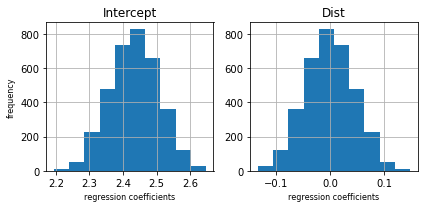

In [125]:
%matplotlib inline  
mrqap.plot('betas', fn=None)